In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import pandas as pd
from tqdm import tqdm as tm

from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device

print(device)

cuda


The RGD stuff seems to have 2 stability-ish issues that needs to be addressed:
1. once in a while, it fails to minimize the out-of-simplex loss
2. it is not really affected by the initial guess

1200:   3%|▎         | 2/71 [00:00<00:29,  2.35it/s]

tensor([[ 1.1416, -0.0753, -0.9197],
        [-0.6364,  0.2478, -1.4472],
        [ 1.1105,  0.3951, -0.9768],
        [ 0.8385,  2.0682, -0.3392],
        [-0.8786,  3.1240,  7.0977],
        [ 3.1860, -0.6109,  7.0941],
        [ 0.9223,  0.8708, -0.9612]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:   4%|▍         | 3/71 [00:01<00:22,  3.03it/s]

tensor([[ 0.1444, -0.8581, -1.7732],
        [-1.0207, -0.1637, -2.0122],
        [ 1.7371,  0.9628, -0.3176],
        [ 0.7076,  1.9624, -0.1310],
        [-1.9542,  2.1439,  6.3263],
        [ 2.0357, -1.8969,  6.3208],
        [ 1.9658,  1.8610, -0.2904]])


1200:   6%|▌         | 4/71 [00:01<00:19,  3.39it/s]

tensor([[ 0.1463, -0.7023, -1.8832],
        [-0.1454,  1.0404, -1.0797],
        [ 1.8747,  0.8659, -0.0267],
        [-0.0864,  0.7458, -1.1355],
        [-2.2021,  1.9697,  6.0351],
        [ 1.4564, -2.5144,  5.7474],
        [ 2.2349,  2.1193, -0.0069]])


1200:   7%|▋         | 5/71 [00:01<00:17,  3.77it/s]

tensor([[ 0.9135, -0.3628, -1.2872],
        [-0.2999,  0.7685, -1.2158],
        [ 0.5174, -0.0115, -1.4506],
        [ 0.2420,  1.2620, -0.9072],
        [-3.2086,  1.0753,  4.5031],
        [ 1.5002, -2.3389,  4.8844],
        [ 2.7961,  2.6319,  1.2727]])


1200:   8%|▊         | 6/71 [00:01<00:17,  3.78it/s]

tensor([[ 0.4209, -0.2304, -1.4496],
        [ 0.4755,  1.5039, -0.5336],
        [ 1.7704,  0.7560, -0.2880],
        [-0.4577,  0.7099, -1.2995],
        [-1.2424,  3.3504,  7.3330],
        [ 2.8142, -0.5449,  7.3191],
        [ 1.1898,  0.6207, -1.2960]])


1200:  11%|█▏        | 8/71 [00:02<00:14,  4.47it/s]

tensor([[ 1.1854,  0.5014, -0.6379],
        [-0.5698,  0.4947, -1.3631],
        [ 0.2329, -1.0255, -1.9579],
        [ 0.2854,  1.1755, -0.8336],
        [-2.5832,  1.2917,  5.6207],
        [ 2.0345, -2.1518,  6.1262],
        [ 2.4222,  2.6126,  0.3072]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  13%|█▎        | 9/71 [00:02<00:13,  4.51it/s]

tensor([[ 0.4749, -0.3851, -1.3728],
        [-0.8101,  0.3278, -1.5393],
        [ 0.9500, -0.0134, -1.1685],
        [ 0.2232,  1.2329, -0.9500],
        [-3.2339,  1.0283,  5.0114],
        [ 0.7850, -2.9456,  4.9172],
        [ 3.2597,  2.9991,  1.0882]])


1200:  14%|█▍        | 10/71 [00:02<00:13,  4.39it/s]

tensor([[ 1.2806,  0.3072, -0.6335],
        [ 0.4478,  1.5851, -0.0404],
        [ 0.8148, -0.0572, -1.4542],
        [-0.5432,  0.4693, -1.9312],
        [-1.0685,  2.8585,  6.6210],
        [ 2.9312, -1.1765,  6.5289],
        [ 1.1774,  1.2796, -0.4522]])


1200:  15%|█▌        | 11/71 [00:02<00:14,  4.26it/s]

tensor([[ 0.7518, -0.1751, -1.2055],
        [-0.5064,  0.3502, -1.4128],
        [ 0.8501, -0.1539, -1.0826],
        [ 0.1985,  1.3618, -0.8078],
        [-2.9563,  1.3536,  5.3811],
        [ 1.6784, -2.0986,  5.9264],
        [ 2.6351,  2.4369,  0.3446]])


1200:  17%|█▋        | 12/71 [00:03<00:14,  3.98it/s]

tensor([[ 0.3665, -0.2893, -1.4800],
        [-0.1284,  0.9344, -1.1987],
        [ 1.5844,  0.1396, -0.6035],
        [ 0.2835,  1.2521, -0.6625],
        [-2.1112,  1.8247,  5.7374],
        [ 2.0294, -1.7602,  5.9776],
        [ 1.9560,  1.9801,  0.0679]])


1200:  20%|█▉        | 14/71 [00:03<00:13,  4.36it/s]

tensor([[ 0.7663, -0.1897, -1.1360],
        [-0.1086,  0.7961, -0.9889],
        [ 0.8133, -0.0792, -1.1945],
        [-0.4777,  0.6961, -1.4894],
        [-2.9910,  1.2880,  5.5193],
        [ 1.0772, -2.8065,  5.4163],
        [ 2.9309,  2.7754,  0.5827]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  21%|██        | 15/71 [00:03<00:13,  4.21it/s]

tensor([[ 0.6011, -0.2723, -1.4690],
        [-0.4993,  0.5529, -1.3402],
        [ 1.6395,  0.4732, -0.2837],
        [ 0.3289,  1.1369, -0.8217],
        [-0.8867,  2.6964,  7.3229],
        [ 2.7462, -1.6157,  7.0126],
        [ 1.1481,  1.5722, -1.0403]])


1200:  24%|██▍       | 17/71 [00:04<00:11,  4.69it/s]

tensor([[ 0.5893, -0.4432, -1.4893],
        [-0.3731,  0.7594, -1.3297],
        [ 1.5463,  0.7689, -0.4415],
        [ 0.5369,  1.4239, -0.5218],
        [-1.5401,  2.4515,  6.4207],
        [ 2.7250, -1.3801,  6.5517],
        [ 1.3697,  1.4017, -0.5104]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  25%|██▌       | 18/71 [00:04<00:11,  4.44it/s]

tensor([[ 0.2086, -1.0476, -2.0269],
        [-0.1587,  0.7865, -1.0777],
        [ 1.6741,  0.9202, -0.1867],
        [-0.4128,  0.6534, -1.4815],
        [-2.6737,  1.1807,  5.1339],
        [ 0.8457, -3.2306,  4.6697],
        [ 2.8443,  2.9861,  1.0376]])


1200:  27%|██▋       | 19/71 [00:04<00:11,  4.48it/s]

tensor([[ 0.3260, -0.5905, -1.8226],
        [-0.2588,  0.6350, -1.3810],
        [ 1.5857,  0.5029, -0.3782],
        [ 0.1627,  1.2263, -0.6528],
        [-1.4865,  2.2132,  6.3302],
        [ 2.5808, -1.7168,  6.3269],
        [ 1.5762,  1.8781, -0.2313]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  30%|██▉       | 21/71 [00:05<00:10,  4.56it/s]

tensor([[ 1.2052,  0.0588, -0.8613],
        [-0.5574,  0.2589, -1.6181],
        [ 0.3434, -0.4261, -1.6885],
        [ 0.2878,  1.6577, -0.5245],
        [-2.9385,  1.1414,  5.0157],
        [ 1.5591, -2.2437,  5.5400],
        [ 2.6870,  2.5584,  0.7370]])


1200:  31%|███       | 22/71 [00:05<00:11,  4.35it/s]

tensor([[ 0.7611, -0.1570, -1.2191],
        [-1.0092,  0.0165, -1.9544],
        [ 0.6578, -0.2947, -1.4376],
        [ 1.0187,  1.9364, -0.0906],
        [-3.1935,  0.8910,  4.7732],
        [ 1.6494, -2.5057,  5.4808],
        [ 2.6656,  2.7172,  0.7933]])


1200:  32%|███▏      | 23/71 [00:05<00:11,  4.36it/s]

tensor([[ 0.2781, -0.5565, -1.4919],
        [-0.9422,  0.1895, -1.8002],
        [ 1.7908,  0.5753, -0.4465],
        [ 0.7902,  1.6187, -0.3685],
        [-1.6607,  2.0934,  6.2665],
        [ 2.0886, -1.9749,  6.1950],
        [ 1.7896,  1.9707, -0.2206]])


1200:  34%|███▍      | 24/71 [00:06<00:11,  4.16it/s]

tensor([[ 0.9793,  0.1066, -1.0120],
        [-0.1057,  0.6432, -1.2361],
        [ 0.6358, -0.1936, -1.2977],
        [-0.5839,  0.8503, -1.2970],
        [-3.5462,  0.9976,  4.9432],
        [ 0.6639, -2.8709,  5.0125],
        [ 3.3192,  2.8403,  0.9354]])


1200:  35%|███▌      | 25/71 [00:06<00:11,  4.01it/s]

tensor([[ 0.9225, -0.0574, -0.9581],
        [-0.2016,  0.8125, -1.1852],
        [ 1.1793,  0.2718, -0.9510],
        [ 0.1876,  1.3041, -0.7722],
        [-1.9223,  2.2748,  6.1434],
        [ 2.2433, -1.5028,  6.2792],
        [ 1.7361,  1.5464, -0.3082]])


1200:  38%|███▊      | 27/71 [00:06<00:09,  4.53it/s]

tensor([[ 0.0811, -1.0840, -2.0805],
        [-0.4462,  0.6431, -1.3023],
        [ 1.9164,  1.0347,  0.0947],
        [ 0.3906,  1.1283, -0.7754],
        [-1.8968,  1.8652,  6.4031],
        [ 1.9986, -2.3488,  6.1928],
        [ 1.9086,  2.2365, -0.2964]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  39%|███▉      | 28/71 [00:06<00:09,  4.47it/s]

tensor([[ 0.0700, -0.5367, -1.8885],
        [-1.2191, -0.0619, -2.1070],
        [ 2.0091,  0.8614, -0.0686],
        [ 1.0692,  2.0812,  0.1452],
        [-2.0245,  2.2780,  6.1899],
        [ 2.2407, -1.5571,  6.2771],
        [ 1.8241,  1.6162, -0.2643]])


1200:  41%|████      | 29/71 [00:07<00:09,  4.25it/s]

tensor([[-0.2848, -1.4311, -2.4704],
        [-0.9588, -0.3504, -2.1325],
        [ 2.3194,  1.5672,  0.4370],
        [ 0.8939,  2.3443,  0.1353],
        [-1.6957,  2.3058,  6.3375],
        [ 2.1789, -1.8343,  6.1597],
        [ 1.6758,  1.6787, -0.3194]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  45%|████▌     | 32/71 [00:07<00:07,  5.01it/s]

tensor([[ 0.6839, -0.2697, -1.2571],
        [-0.4434,  0.9684, -1.1050],
        [ 0.9734,  0.0525, -1.1463],
        [-0.0995,  0.5442, -1.3709],
        [-2.7094,  1.5439,  5.4290],
        [ 1.2995, -2.6296,  5.3112],
        [ 2.7274,  2.6230,  0.6921]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  46%|████▋     | 33/71 [00:07<00:07,  4.97it/s]

tensor([[ 1.0410,  0.3385, -0.6627],
        [ 0.2153,  1.2723, -0.5611],
        [ 0.9405, -0.1371, -1.2993],
        [-0.6380,  0.5750, -1.4785],
        [-2.4115,  1.8596,  6.1346],
        [ 1.5345, -2.0159,  5.9499],
        [ 2.3600,  2.0380, -0.0860]])


1200:  48%|████▊     | 34/71 [00:08<00:07,  4.85it/s]

tensor([[-0.1718, -1.1249, -1.8993],
        [-0.8770,  0.0971, -1.6937],
        [ 2.3421,  1.0754,  0.1171],
        [ 0.9017,  1.5518, -0.4746],
        [-1.5172,  1.9245,  6.5096],
        [ 2.0960, -2.6671,  6.1065],
        [ 1.6506,  2.3066, -0.3472]])


1200:  49%|████▉     | 35/71 [00:08<00:07,  4.66it/s]

tensor([[ 0.2571, -0.8005, -1.6355],
        [-0.3488,  0.3996, -1.6440],
        [ 1.9117,  1.2824, -0.1146],
        [ 0.3534,  1.7538, -0.1895],
        [-1.5915,  2.8914,  6.8758],
        [ 2.7316, -0.9224,  7.1654],
        [ 1.4003,  0.9999, -1.0001]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  54%|█████▎    | 38/71 [00:08<00:06,  5.09it/s]

tensor([[ 0.9286, -0.0219, -1.0546],
        [-0.6957,  0.5291, -1.3948],
        [ 0.7021, -0.0947, -1.3051],
        [ 0.0771,  0.9574, -1.0993],
        [-3.2531,  1.1203,  5.1527],
        [ 1.1501, -2.7156,  5.4164],
        [ 2.9927,  2.7976,  0.7524]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  55%|█████▍    | 39/71 [00:09<00:06,  4.74it/s]

tensor([[ 1.1578, -0.0765, -0.8758],
        [-0.7591,  0.0938, -1.7724],
        [ 0.6033, -0.0456, -1.3957],
        [ 0.4971,  1.6675, -0.4888],
        [-2.3531,  1.7730,  5.5653],
        [ 1.5887, -2.3655,  5.5017],
        [ 2.3702,  2.2796,  0.4475]])


1200:  56%|█████▋    | 40/71 [00:09<00:06,  4.55it/s]

tensor([[ 0.3281, -0.5385, -1.5681],
        [-0.6434,  0.3047, -1.7627],
        [ 1.1874,  0.0601, -0.8867],
        [-0.1890,  0.8183, -1.1309],
        [-3.7624,  0.2396,  4.3712],
        [ 0.0618, -3.9238,  4.2295],
        [ 3.7045,  3.7648,  1.6105]])


1200:  58%|█████▊    | 41/71 [00:09<00:06,  4.32it/s]

tensor([[ 0.2485, -0.6606, -1.6927],
        [-1.0300, -0.4058, -1.9949],
        [ 1.3186,  0.4871, -0.5303],
        [ 0.6821,  2.2429,  0.0702],
        [-2.6075,  1.5323,  6.1853],
        [ 1.8602, -1.9983,  6.5062],
        [ 2.4139,  2.2806, -0.2925]])


1200:  61%|██████    | 43/71 [00:10<00:06,  4.60it/s]

tensor([[ 0.2742, -0.4686, -1.6308],
        [-1.5725, -0.4960, -2.4816],
        [ 1.6004,  0.3382, -0.4804],
        [ 1.4203,  2.3206,  0.3218],
        [-2.4562,  1.4682,  5.5796],
        [ 1.7558, -2.2909,  5.8677],
        [ 2.2540,  2.3390,  0.2072]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  63%|██████▎   | 45/71 [00:10<00:05,  4.88it/s]

tensor([[ 0.1292, -0.9587, -1.9018],
        [-0.5836,  0.3234, -1.3565],
        [ 1.9516,  1.0646, -0.0407],
        [ 0.5066,  1.5971, -0.6795],
        [-1.7479,  2.1079,  6.3500],
        [ 2.1360, -2.0167,  6.1400],
        [ 1.7892,  1.9312, -0.2538]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  65%|██████▍   | 46/71 [00:10<00:04,  5.27it/s]

tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  66%|██████▌   | 47/71 [00:10<00:04,  4.81it/s]

tensor([[ 0.6686, -0.5349, -1.5791],
        [-0.5491,  0.3179, -1.5078],
        [ 0.9677,  0.3057, -0.8144],
        [ 0.1891,  1.4222, -0.7687],
        [-3.0077,  1.1480,  5.0598],
        [ 0.9692, -2.8789,  5.0088],
        [ 2.9108,  2.7663,  0.8561]])


1200:  68%|██████▊   | 48/71 [00:11<00:05,  4.33it/s]

tensor([[-0.0848, -0.9919, -2.1173],
        [-0.7693,  0.3703, -1.7329],
        [ 1.6629,  0.8806, -0.2908],
        [ 0.2844,  1.4028, -0.5230],
        [-2.7463,  1.6103,  5.5772],
        [ 1.0317, -2.6425,  5.2169],
        [ 2.9001,  2.5635,  0.6570]])


1200:  70%|███████   | 50/71 [00:11<00:04,  4.62it/s]

tensor([[ 0.9104, -0.2991, -1.0091],
        [-0.1900,  0.8629, -1.2425],
        [ 0.3079, -0.2034, -1.8860],
        [-0.3490,  0.7035, -1.3229],
        [-3.9167,  0.3914,  3.9648],
        [ 0.8031, -3.0684,  4.6810],
        [ 3.4588,  3.2269,  1.6116]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  73%|███████▎  | 52/71 [00:12<00:03,  4.78it/s]

tensor([[ 0.3438, -0.6469, -1.6461],
        [-1.3763, -0.3053, -2.3560],
        [ 1.6880,  0.8633, -0.2449],
        [ 1.3032,  2.3656,  0.4718],
        [-2.2115,  2.0785,  6.1436],
        [ 1.6948, -2.1089,  6.1047],
        [ 2.1418,  1.8938, -0.2371]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  75%|███████▍  | 53/71 [00:12<00:04,  4.49it/s]

tensor([[ 0.3329, -0.6611, -1.7268],
        [-0.0251,  1.1289, -0.7745],
        [ 1.4401,  0.5192, -0.4739],
        [-0.0207,  0.7586, -1.2175],
        [-2.3549,  1.6330,  6.0258],
        [ 2.3294, -1.8535,  6.5302],
        [ 2.0723,  2.2208, -0.1533]])


1200:  77%|███████▋  | 55/71 [00:12<00:03,  4.61it/s]

tensor([[ 0.3877, -0.6878, -1.5685],
        [-0.2433,  0.8827, -1.0072],
        [ 1.3890,  0.3791, -0.6990],
        [-0.2267,  0.5307, -1.4706],
        [-2.6184,  1.0145,  5.3599],
        [ 1.1475, -3.2891,  5.1585],
        [ 2.6868,  3.1234,  0.7327]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  79%|███████▉  | 56/71 [00:13<00:03,  4.40it/s]

tensor([[ 0.6694, -0.2423, -1.2563],
        [ 0.1072,  0.8025, -1.1350],
        [ 1.4492,  0.3015, -0.5902],
        [-0.3260,  0.9383, -1.0655],
        [-1.8150,  2.0778,  6.2186],
        [ 1.3716, -2.6154,  5.4848],
        [ 2.1315,  2.2235,  0.0512]])


1200:  80%|████████  | 57/71 [00:13<00:03,  4.15it/s]

tensor([[-0.1560, -0.9909, -1.9408],
        [-0.7109,  0.6130, -1.5444],
        [ 1.1317,  0.1619, -1.1077],
        [-0.1877,  0.6681, -1.1549],
        [-4.3568, -0.0475,  3.8937],
        [-0.0889, -3.7497,  4.2646],
        [ 4.2187,  3.9279,  1.9521]])


1200:  82%|████████▏ | 58/71 [00:13<00:03,  4.13it/s]

tensor([[-0.0887, -0.9053, -2.1186],
        [-0.6463,  0.2594, -1.6290],
        [ 1.5752,  0.4696, -0.2415],
        [ 0.3003,  1.4545, -0.6228],
        [-2.7741,  1.4810,  5.8924],
        [ 1.4834, -2.1298,  6.1738],
        [ 2.6295,  2.3801,  0.0101]])


1200:  83%|████████▎ | 59/71 [00:13<00:02,  4.10it/s]

tensor([[ 0.9214,  0.0445, -1.0202],
        [ 0.0764,  1.1496, -1.0761],
        [ 0.7564, -0.2871, -1.4112],
        [-0.2664,  0.7034, -1.1052],
        [-2.6665,  1.4594,  5.2100],
        [ 1.7564, -2.1852,  5.6643],
        [ 2.4225,  2.3611,  0.5629]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  87%|████████▋ | 62/71 [00:14<00:01,  5.22it/s]

tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  89%|████████▊ | 63/71 [00:14<00:01,  4.91it/s]

tensor([[ 0.0267, -0.8899, -1.8141],
        [-0.4197,  0.5349, -1.2329],
        [ 1.3325,  0.3928, -0.7248],
        [-0.5127,  0.5154, -1.6375],
        [-3.6676,  0.4879,  4.7464],
        [-0.5168, -4.6097,  3.8319],
        [ 4.0168,  3.9756,  1.6826]])


1200:  90%|█████████ | 64/71 [00:14<00:01,  4.42it/s]

tensor([[-0.1692, -1.2778, -2.6179],
        [ 0.1265,  1.0089, -0.8064],
        [ 1.4234,  0.7614, -0.1373],
        [-0.8466,  0.4224, -1.6236],
        [-3.1378,  1.0109,  5.2908],
        [ 1.1983, -2.7682,  5.3163],
        [ 3.0760,  3.0307,  0.8391]])


1200:  92%|█████████▏| 65/71 [00:15<00:01,  4.17it/s]

tensor([[ 0.7097, -0.1440, -1.1325],
        [-0.6526,  0.1081, -1.5536],
        [ 1.2857,  0.3634, -0.5629],
        [ 0.2235,  1.6194, -0.4115],
        [-1.9938,  2.3876,  7.1826],
        [ 1.6791, -2.0085,  6.6671],
        [ 2.1163,  1.8828, -0.8939]])


1200:  93%|█████████▎| 66/71 [00:15<00:01,  4.00it/s]

tensor([[-0.7659, -1.5684, -2.5748],
        [ 0.0487,  1.1586, -0.7614],
        [ 3.1766,  2.2784,  0.9782],
        [-0.0201,  1.1798, -0.7733],
        [-0.5470,  3.7412,  7.7961],
        [ 2.5705, -1.0358,  7.0299],
        [ 0.9359,  0.6089, -1.4724]])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


1200:  96%|█████████▌| 68/71 [00:15<00:00,  4.19it/s]

tensor([[ 0.9457,  0.0317, -0.9647],
        [-0.6956,  0.4080, -1.6380],
        [ 0.9211,  0.0070, -1.1612],
        [ 0.3789,  1.2665, -0.6290],
        [-2.7086,  1.5223,  5.5304],
        [ 1.7992, -2.1820,  5.9787],
        [ 2.4098,  2.3215,  0.2286]])


1200:  97%|█████████▋| 69/71 [00:16<00:00,  4.13it/s]

tensor([[ 0.4308, -0.6244, -1.5096],
        [-0.2726,  0.8665, -1.2008],
        [ 1.4585,  1.0874, -0.4127],
        [-0.0097,  1.1709, -0.7689],
        [-2.5500,  2.4773,  6.3523],
        [ 1.4843, -1.8770,  6.0868],
        [ 2.4224,  1.6107, -0.2762]])


1200:  99%|█████████▊| 70/71 [00:16<00:00,  4.16it/s]

tensor([[ 0.5081, -0.2875, -1.3727],
        [ 0.0564,  1.2747, -0.7501],
        [ 1.4897,  0.3694, -0.6969],
        [-0.3818,  0.3290, -1.7076],
        [-2.4754,  1.6433,  5.4329],
        [ 1.8437, -2.1849,  5.6789],
        [ 2.3133,  2.2956,  0.4780]])


1200:  99%|█████████▊| 70/71 [00:17<00:00,  4.07it/s]


IndexError: too many indices for tensor of dimension 2

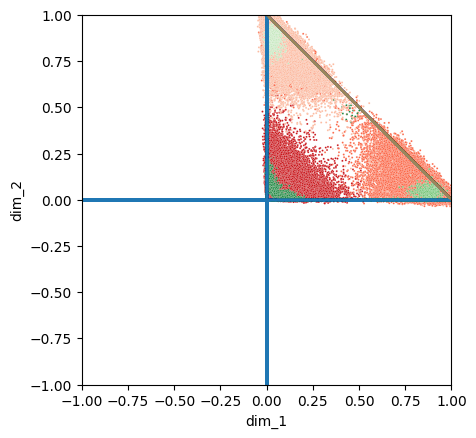

In [2]:
N = 71
temp = sim.ABC_Monte_Carlo.consistency_T2(number_of_iterations = N, 
                                          nodes_set = [1200],
                                          beta = [1,1,-4, 5],
                                          alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]],
                                          seeded = True,
                                          constrained = False,
                                          oracle_lat_pos = False,
                                          oracle_align = False,
                                          no_oracle = True)

In [ ]:
model = sim.ABC(time = 2,
            nodes = 3,
            beta = [1,1,-3, 5],
            alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
C = model.settings.C

res = torch.tensor(temp.MC_result.est["B_est"]).reshape(N, 21).T

torch.linalg.solve(C.T @ C, C.T @ res).T

2 tensor(2.4364) tensor(0.1106)
3 tensor(2.0382) tensor(0.0743)
4 tensor(2.0050) tensor(0.0331)
5 tensor(1.9177) tensor(0.0563)
6 tensor(2.0558) tensor(0.1144)
7 tensor(1.9242) tensor(0.0569)
8 tensor(2.2786) tensor(0.1564)
9 tensor(1.8439) tensor(0.1836)
10 tensor(1.9515) tensor(0.1127)
11 tensor(2.3491) tensor(0.1460)
12 tensor(2.0015) tensor(0.1593)
13 tensor(2.2002) tensor(0.0589)
14 tensor(2.0971) tensor(0.1494)
15 tensor(2.2425) tensor(0.0637)
16 tensor(2.1402) tensor(0.0582)
17 tensor(2.0923) tensor(0.1320)
18 tensor(1.9562) tensor(0.0725)
19 tensor(2.1774) tensor(0.2158)
20 tensor(2.2165) tensor(0.1046)
21 tensor(1.6643) tensor(0.0893)
22 tensor(2.1406) tensor(0.0660)
23 tensor(2.2916) tensor(0.1380)
24 tensor(1.8461) tensor(0.0860)
25 tensor(1.8939) tensor(0.1345)
26 tensor(2.2121) tensor(0.0265)
27 tensor(1.9628) tensor(0.0944)
28 tensor(2.0585) tensor(0.1300)
29 tensor(1.7679) tensor(0.1271)
30 tensor(2.0629) tensor(0.1721)
31 tensor(1.8046) tensor(0.1074)
32 tensor(2.2724) 

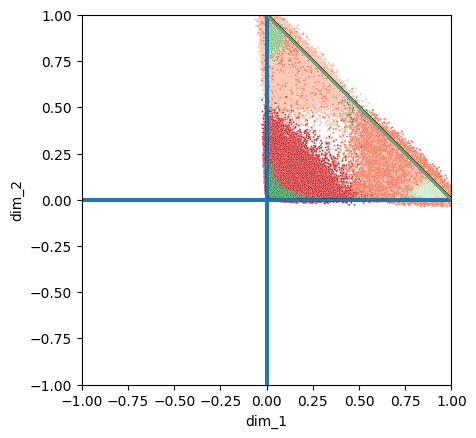

In [4]:
i = 1
while i <= 200:
    model = sim.ABC(time = 2,
            nodes = 3,
            beta = [1,1,-4, 5],
            alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
    p = model.settings.p
    torch.manual_seed(i)
    model.update_settings(nodes = 1200)
    Z0 = model.synth_data["lat_pos"][0,]
    Z1 = model.synth_data["lat_pos"][1,]
    Y0 = model.synth_data["obs_adj"][0,]
    Y1 = model.synth_data["obs_adj"][1,]


    Z0_no_oracle = Align.No_Oracle(Y0, (p-1)).aligned
    vls.lat_vis(df = Z0_no_oracle, 
                K = 3,
                LB = -1, 
                palette = "Reds")

    Z1_no_oracle = Align.No_Oracle(Y1, (p-1)).aligned
    vls.lat_vis(df = Z1_no_oracle, 
                K = 3,
                LB = -1, 
                palette = "Greens")
    i += 1
    print(i, 
        Align.Op_Riemannian_GD.simplex_loss_relu(Z0_no_oracle),
        Align.Op_Riemannian_GD.simplex_loss_relu(Z1_no_oracle))

In [ ]:
model = sim.ABC(time = 2,
                nodes = 3,
                beta = [1,1,-10, 5],
                alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
p = model.settings.p
torch.manual_seed(1)
model.update_settings(nodes = 1200)
Z0 = model.synth_data["lat_pos"][0,]
Z1 = model.synth_data["lat_pos"][1,]
Y0 = model.synth_data["obs_adj"][0,]
Y1 = model.synth_data["obs_adj"][1,]


ASE_0 = Align.Oracle.ASE(Y0, (p-1))
ASE_1 = Align.Oracle.ASE(Y1, (p-1))

A_mat_0 = Align.Op_Riemannian_GD(ASE_0, "relu").align_mat
A_mat_1 = Align.Op_Riemannian_GD(ASE_1, "softplus", softplus_parameter= 5).align_mat

aligned_0 = ASE_0 @ A_mat_0
aligned_1 = ASE_1 @ A_mat_1

vls.lat_vis(df = aligned_0, K = 3, LB = -1, palette= "Reds")
vls.lat_vis(df = aligned_1, K = 3, LB = -1, palette= "Greens")
